# Rheological analysis of polystyrene storage and loss modulus mastercurve
 
This notebook performs a rheological analysis of polystyrene at various temperatures, using logarithmic transformations, shift factors, master curve construction, and rheological modeling. The raw data was obtained from . G. Ricarte and S. Shanbhag, Polymer Chemistry, 2024, 15, 815–846.

We import:
- `pandas` for reading and manipulating data.
- `numpy` for mathematical computations like logarithmic transformations.
- `matplotlib.pyplot` for detailed visualizations.
- `re` for regex operations to extract temperaturetemperatures information from filenames.
- `mastercurves` and `pyRheo` for master curve construction and model fitting.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from mastercurves import MasterCurve
from mastercurves.transforms import Multiply
from pyRheo.oscillation_model import OscillationModel


# Load and process polystyrene data
This cell loads experimental data from a CSV file containing:
- Angular Frequency (`omega`) in [rad/s].
- Storage Modulus (`G_prime`) in [Pa].
- Loss Modulus (`G_double_prime`) in [Pa].

The data is loaded using `pandas` and the first few rows are displayed for verification.

1. Data files for different temperatures are read.
2. Angular frequecy and storage and loss modulus data are logarithmically transformed for analysis.
4. Temperatures values are extracted from filenames using regex.
5. Log-transformed data is stored in separate lists for further analysis.


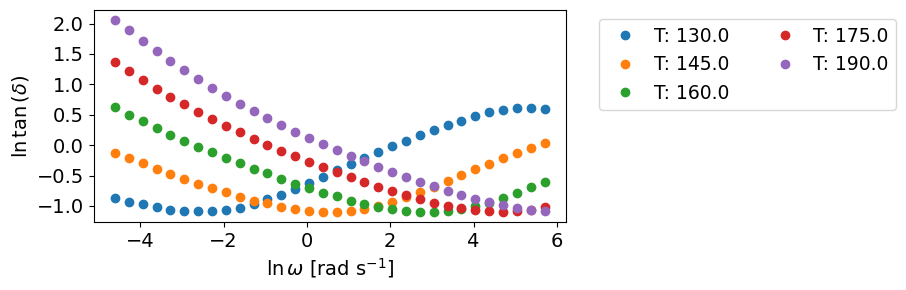

In [2]:
# List of files containing data at various temperatures
filenames = [
    './data/polystyrene/oscillation_ps130_data.csv',
    './data/polystyrene/oscillation_ps145_data.csv',
    './data/polystyrene/oscillation_ps160_data.csv',
    './data/polystyrene/oscillation_ps175_data.csv',    
    './data/polystyrene/oscillation_ps190_data.csv'
]

# Define column names and initialize lists for storing data
columns = ['Angular Frequency', 'Storage Modulus', 'Loss Modulus']
omega_log_list, G_prime_log_list, G_double_prime_log_list, tan_delta_log_list, temp_list = [], [], [], [], []

# Initialize figure for visualization
plt.figure(figsize=(6, 3))

# Loop through files to process data
for filename in filenames:
    data = pd.read_csv(filename, decimal='.', encoding='utf-8', sep='\t')
    data.columns = columns
    
    # Log-transform angular frequency and moduli
    log_interval_omega = np.log(data['Angular Frequency'])
    log_storage_modulus = np.log(data['Storage Modulus'])
    log_loss_modulus = np.log(data['Loss Modulus'])

    # Append the log-transformed data to the lists[i]
    omega_log_list.append(np.array(log_interval_omega))
    G_prime_log_list.append(np.array(log_storage_modulus))
    G_double_prime_log_list.append(np.array(log_loss_modulus))

    # Get tan delta and append it
    log_tan_delta = log_loss_modulus - log_storage_modulus
    tan_delta_log_list.append(np.array(log_tan_delta))

    # Extract temperature from filename
    match = re.search(r'ps(\d+)_data\.csv$', filename)
    if match:
        temp = float(match.group(1))
        temp_list.append(temp)
        plt.plot(log_interval_omega, log_tan_delta, 'o', label=f'T: {temp}')
    else:
        print(f"Warning: No temperatures found in filename {filename}")

# Finalize the plot
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r'$\ln \omega$ [rad s$^{-1}$]', fontsize=14)
plt.ylabel(r'$\ln \tan{(\delta)}$', fontsize=14)
plt.legend(fontsize=13.5, handletextpad=0.5, ncol=2, bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


# Construct master curve
1. Use the `MasterCurve` class to build a master curve for the polystyrene data.
2. Horizontal and vertical transformations are applied using logarithmic scaling.
3. Superposition is performed to align the datasets.
4. The shift factors for aligning the data are extracted.


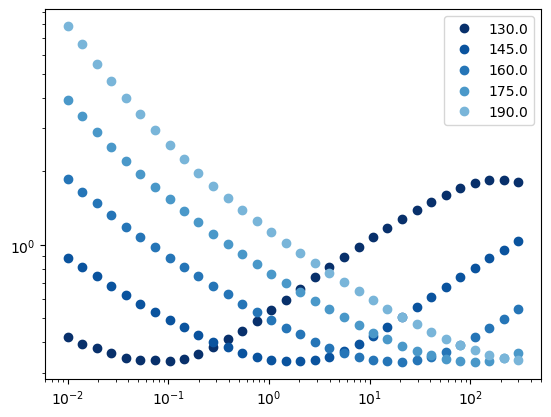

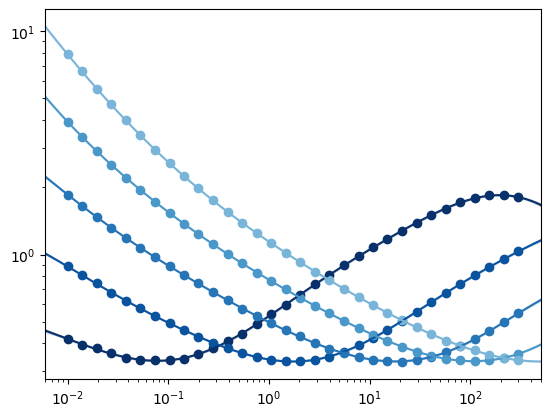

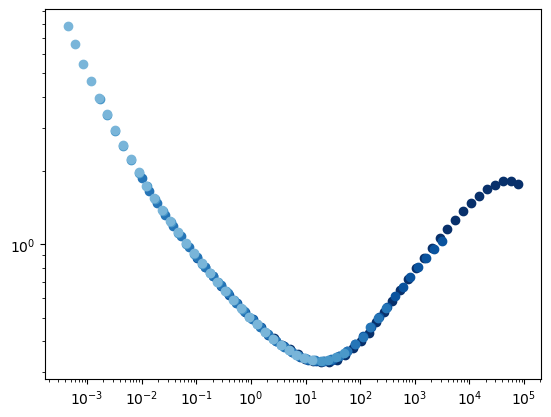

In [3]:
# Build a master curve using the MasterCurve library
mc = MasterCurve()
mc.add_data(omega_log_list, tan_delta_log_list, temp_list)

# Adjust GPR kernel
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel
kernel = (ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-10, 1e2)) * RBF(length_scale=[1], length_scale_bounds=(1e-10, 1e2)) + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-10, 1e1)))
mc.set_gp_kernel(kernel)

# Apply logarithmic transformations for horizontal and vertical shifts
mc.add_htransform(Multiply(scale="log")) # natural log
mc.add_vtransform(Multiply(scale="log")) # natural log

# Perform superposition
mc.superpose()

# Change reference temperature
mc.change_ref(160)

# Plot the master curve and extract shift factors
fig1, ax1, fig2, ax2, fig3, ax3 = mc.plot(colormap=lambda i: plt.cm.Blues_r(i / 1.5))
hshift_factors = [np.array(np.log(factor)) for factor in mc.hparams[0]]
vshift_factors = [np.array(np.log(factor)) for factor in mc.vparams[0]]


# Plot shift factors as a function of temperature


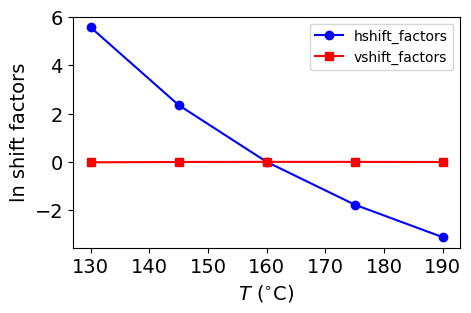

In [4]:
# Create the plot
plt.figure(figsize=(5, 3))

# Plot both factors
plt.plot(temp_list, hshift_factors, label="hshift_factors", marker='o', color='blue')
plt.plot(temp_list, vshift_factors, label="vshift_factors", marker='s', color='red')

# Add labels and title
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('$T$ ($^{\circ}$C)', fontsize=14)
plt.ylabel('ln shift factors', fontsize=14)

# Add a legend
plt.legend()

# Show the plot
plt.show()

# Apply shift factors to data
1. Shift factors are used to align all datasets onto a single master curve.
2. Log-transformed data is shifted and converted back to the original scale.
3. The combined angular frequency and moduli values are stored for further analysis.


In [5]:
shifted_omega, shifted_G_prime, shifted_G_double_prime = [], [], []

for idx, (omega_log, G_prime_log, G_double_prime_log) in enumerate(zip(omega_log_list, G_prime_log_list, G_double_prime_log_list)):
    # Apply shift factors
    shifted_omega_log = omega_log + hshift_factors[idx]
    shifted_G_prime_log = G_prime_log + vshift_factors[idx]
    shifted_G_double_prime_log = G_double_prime_log + vshift_factors[idx]


    # Convert back to linear scale and append
    shifted_omega = np.concatenate([shifted_omega, np.exp(shifted_omega_log)])    
    shifted_G_prime = np.concatenate([shifted_G_prime, np.exp(shifted_G_prime_log)])
    shifted_G_double_prime = np.concatenate([shifted_G_double_prime, np.exp(shifted_G_double_prime_log)])
    

# Organize and visualize shifted data
1. Create a DataFrame from the shifted angular frequency and moduli arrays.
2. Clean the data by removing NaN values.
3. Reorder the DataFrame by shear rate for consistent visualization.
4. Plot the shifted data to validate the alignment from the master curve transformation.


   Angular Frequency  Storage Modulus  Loss Modulus
0           0.000441       104.175212    820.720185
1           0.000613       168.616356   1115.595068
2           0.000856       273.407753   1509.954198
3           0.001195       426.251732   2003.499419
4           0.001667       661.644776   2644.730544


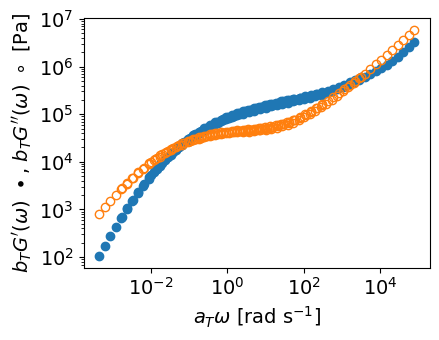

In [6]:
# Create a DataFrame from shifted angular frequency and moduli arrays
df = pd.DataFrame({'Angular Frequency': shifted_omega, 'Storage Modulus': shifted_G_prime, 'Loss Modulus': shifted_G_double_prime})

# Clean NaNs
df_cleaned = df.dropna()

# Reorder the DataFrame by 'Angular Frequency' from minimum to maximum
df_sorted = df_cleaned.sort_values(by='Angular Frequency', ascending=True).reset_index(drop=True)

# Show the DataFrame (optional)
print(df_sorted.head())

# Plot
plt.figure(figsize=(4.5, 3.5))
plt.plot(shifted_omega, shifted_G_prime, "o")
plt.plot(shifted_omega, shifted_G_double_prime, "o", fillstyle='none')


# Customize the plot
plt.xscale("log")
plt.yscale("log")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r'$a_{T} \omega$ [rad s$^{-1}$]', fontsize=14)
plt.ylabel(r'$b_{T}G^{\prime}(\omega)~\bullet$, $b_{T}G^{\prime \prime}(\omega)~\circ$ [Pa]', fontsize=14)
plt.grid(False)
plt.tight_layout()
plt.show()


# Fit model to master curve with pyRheo

1. The master curve data (oscillation and moduli) is used for model fitting.
2. The `pyRheo` library is employed to fit a FractionalZenerLiquidD model.
3. The model parameters, fitting error, and predictions are displayed.


Best initial guess was: [328485568.56382155, 58041131.66162759, 281315664.3442549, 0.3833138120099231]
eta_s: 88.14757549961321
eta_p: 1763666.3428599907
G: 81689.95933632739
beta: 0.24714864894830121
RSS: 8.67354877728733
Mean Percentage Error: 13.26%


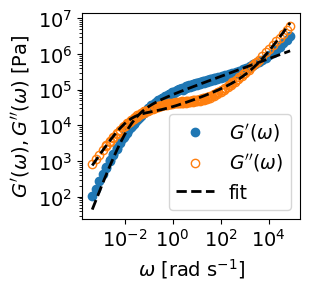

In [7]:
# Load master curve data
omega_mc = df_sorted['Angular Frequency'].values
G_prime_mc = df_sorted['Storage Modulus'].values
G_double_prime_mc = df_sorted['Loss Modulus'].values


# Model fitting
model = OscillationModel(model="FractionalZenerLiquidD", initial_guesses="random", num_initial_guesses=64, minimization_algorithm="Powell")
model.fit(omega_mc, G_prime_mc, G_double_prime_mc)

model.print_parameters()
model.print_error()
model.plot(omega_mc, G_prime_mc, G_double_prime_mc, savefig=False)

# Plot the master curve with colors and fitted prediction
1. Use the previously calculated horizontal (`hshift_factors`) and vertical (`vshift_factors`) shift factors to align data from multiple datasets.
2. Load the datasets and apply transformations to angular frequency and moduli using the shift factors.
3. Generate a color-coded plot for each dataset showing the aligned data.
4. Overlay the master curve prediction from the fitted model for comparison.
5. Customize the plot with labels, scales, and legends, and save the final visualization.


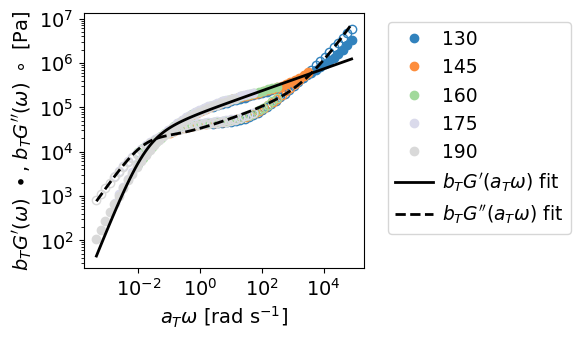

In [8]:
# Import packages for plotting
import matplotlib as mpl
from matplotlib.ticker import LogLocator

# Plot master curve labeled with the model prediction
omega_predict = np.logspace(np.min(np.log10(omega_mc)), np.max(np.log10(omega_mc)), 100)
G_prime_predict, G_double_prime_predict = model.predict(omega_predict)


# List of files to process
sorted_filenames = [
    './data/polystyrene/oscillation_ps130_data.csv',
    './data/polystyrene/oscillation_ps145_data.csv',
    './data/polystyrene/oscillation_ps160_data.csv',
    './data/polystyrene/oscillation_ps175_data.csv',    
    './data/polystyrene/oscillation_ps190_data.csv'
]


num_files = len(sorted_filenames)

# Adjusted size for better visibility of multiple plots
plt.figure(figsize=(6, 3.5))

# Labels for each temperature data
labels = [
    "130", "145", "160", "175",
    "190"
]

# Get the colormap (this returns a continuous colormap)
colormap = mpl.colormaps['tab20c']

# Convert it to a discrete colormap with 'num_files' colors
colors = colormap(np.linspace(0, 1, num_files))

# Store legend handles for different temperatures
temp_handles = []

# Plot data
for i, filename in enumerate(sorted_filenames):
    # Load the data from the CSV file
    data = pd.read_csv(filename, decimal='.', encoding='utf-8', sep='\t')
    data.columns = columns

    # Extract and log-transform the 'Angular Frequency', 'Storage Modulus', and 'Loss Modulus' columns
    log_interval_omega = np.log(data['Angular Frequency'])
    log_G_prime = np.log(data['Storage Modulus'])
    log_G_double_prime = np.log(data['Loss Modulus'])

    # Apply shift factor
    log_interval_omega_shifted = log_interval_omega + hshift_factors[i]
    log_interval_G_prime_shifted = log_G_prime + vshift_factors[i]
    log_interval_G_double_prime_shifted = log_G_double_prime + vshift_factors[i]


    # Get label and color
    label = labels[i]
    color = colors[i % len(colors)]

    # Plot data with shifts applied
    plt.plot(np.exp(log_interval_omega_shifted), np.exp(log_interval_G_prime_shifted), 'o', 
             color=color, markersize=6, alpha=1, label=label)
    plt.plot(np.exp(log_interval_omega_shifted), np.exp(log_interval_G_double_prime_shifted), 'o', 
             color=color, markersize=6, alpha=1, fillstyle='none')
    
# Plot master curve fit
plt.plot(omega_predict, G_prime_predict, '-', color="k", lw=2, label='$b_{T}G^{\prime}(a_{T} \omega)$ fit')
plt.plot(omega_predict, G_double_prime_predict, '--', color="k", lw=2, label='$b_{T}G^{\prime \prime}(a_{T} \omega)$ fit')


# Customize the plot
plt.xscale("log")
plt.yscale("log")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r'$a_{T} \omega$ [rad s$^{-1}$]', fontsize=14)
plt.ylabel(r'$b_{T}G^{\prime}(\omega)~\bullet$, $b_{T}G^{\prime \prime}(\omega)~\circ$ [Pa]', fontsize=14)
plt.legend(fontsize=13.5, loc='upper left', handletextpad=0.5, bbox_to_anchor=(1.05, 1))
plt.grid(False)
plt.tight_layout()

# Display the plot
plt.show()
